In [2]:
import numpy as np
import pandas as pd
from load import Dataset

In [28]:
d = Dataset("cellcycle", nan_strategy="mean")

In [4]:
x_train = d.x_train()

In [5]:
x_train_complete = x_train.dropna()

In [6]:
x_test = d.x_test()
x_test_complete = x_test.dropna()

In [7]:
y_train = d.y_train()

In [8]:
y_train_complete = y_train[x_train_complete.index]
y_train_complete

0          [[11, 02, 01], [11, 02, 02], [11, 02, 03, 01]]
1                                          [[12, 04, 02]]
2       [[01, 04], [14, 01], [14, 04], [16, 01], [16, ...
3              [[10, 03, 02], [42, 10], [43, 01, 03, 09]]
4                            [[10, 01, 05, 01], [32, 01]]
                              ...                        
1623                                   [[11, 02, 03, 04]]
1624    [[16, 19, 03], [20, 01, 27], [20, 03, 22], [32...
1625                 [[11, 02, 03, 01], [11, 02, 03, 04]]
1626                 [[32, 05, 01, 03, 03], [32, 07, 03]]
1627                               [[20, 01, 01, 01, 01]]
Name: class, Length: 1628, dtype: object

In [9]:
y_test = d.y_test()
y_test_complete = y_test[x_test_complete.index]

In [10]:
from sklearn.tree import DecisionTreeClassifier
from hiclass import MultiLabelLocalClassifierPerNode

# Use decision tree classifiers for every node
tree = DecisionTreeClassifier()
classifier = MultiLabelLocalClassifierPerNode(local_classifier=tree)

# Train local classifier per node
classifier.fit(x_train_complete, y_train_complete)

# Predict
predictions = classifier.predict(x_test_complete)
print(predictions)

[[['11' '02' '03' '04' '01' '']
  ['11' '04' '01' '' '' '']
  ['11' '04' '03' '01' '10' '']
  ...
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']]

 [['11' '02' '03' '01' '01' '']
  ['11' '02' '03' '04' '01' '']
  ['11' '02' '03' '04' '03' '']
  ...
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']]

 [['11' '04' '03' '01' '10' '']
  ['43' '01' '03' '05' '' '']
  ['' '' '' '' '' '']
  ...
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']]

 ...

 [['42' '04' '03' '' '' '']
  ['42' '16' '' '' '' '']
  ['42' '01' '' '' '' '']
  ...
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']]

 [['01' '05' '06' '07' '' '']
  ['01' '05' '09' '04' '' '']
  ['01' '05' '09' '07' '' '']
  ...
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']]

 [['01' '20' '17' '01' '' '']
  ['01' '20' '17' '03' '' '']
  ['01' '20' '31' '' '' '']
  ...
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']
  ['' '' '' '' '' '']]]


In [11]:
from typing import List, TypeVar

T = TypeVar("T")

def flatten(xss: List[List[T]]) -> List[T]:
    return [x
            for xs in xss
            for x in xs]

In [12]:
y_valid = d.y_valid()

In [13]:
print(y_train.shape, y_test.shape, y_valid.shape)

(1628,) (1281,) (848,)


In [14]:
from typing import Any, Callable, Dict, Iterable, List, Hashable, Optional, Sequence, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import pydot

def rename_nodes(ys: Sequence[Sequence[Sequence[str]]],
                 root: Hashable = '0') -> Tuple[
                     List[List[List[str]]],
                     Dict[int, int]
                 ]:
    ys = list(ys)
    ys = deepcopy(ys)

    max_level = max(len(path) for paths in ys for path in paths)
    node_map: List[Dict[str, int]] = [{
        root: 0,
    }, {}]
    count = 1
    for level in range(max_level):
        for paths in ys:
            for path in paths:
                if level < len(path):
                    node = path[level]
                    if node not in node_map[level + 1]:
                        node_map[level + 1][node] = count
                        count += 1
                    path[level] = node_map[level + 1][node]
        node_map.append({})

    node_map.pop()

    return ys, node_map
    

def build_hierarchy_graph(ys: List[List[List[str]]], root: Hashable = 0) -> nx.DiGraph:
    G = nx.DiGraph()
    for paths in ys:
        for path in paths:
            G.add_edge(root, path[0])
            for i in range(len(path) - 1):
                G.add_edge(path[i], path[i + 1])
    
    return G


def show_hierarchy_graph(G: nx.DiGraph,
                         nodes: Optional[Iterable[Tuple[Iterable[int], str]]] = None,
                         edges: Optional[Iterable[Tuple[Iterable[Tuple[int, int]], str]]] = None,
                         figsize: Tuple[int, int] = (12, 9),
                         title: str = "Hierarchy Tree",
                         graph_kwargs: Dict[str, Any] = {},
                         nodes_kwargs: Dict[str, Any] = {},
                         edges_kwargs: Dict[str, Any] = {},
                         labels_kwargs: Dict[str, Any] = {}) -> None:
    def_kwargs = dict(with_labels=True,
                      font_weight='bold',
                      arrows=True)
    def_kwargs.update(graph_kwargs)

    pos = graphviz_layout(G, prog='dot')
    plt.figure(figsize=figsize)
    
    nx.draw(G,
            pos,
            **def_kwargs)
    
    if nodes:
        for ns, color in nodes:
            nx.draw_networkx_nodes(G,
                                   pos,
                                   nodelist=ns,
                                   **dict(nodes_kwargs, node_color=color))
    if edges:
        for es, color in edges:
            nx.draw_networkx_edges(G,
                                   pos,
                                   edgelist=es,
                                   **dict(edges_kwargs, edge_color=color))
    if def_kwargs['with_labels']:
        nx.draw_networkx_labels(G,
                                pos,
                                **labels_kwargs)
    
    plt.title(title)
    plt.show()


In [15]:
y_t, node_map = rename_nodes(y_train)
print(node_map)

[{'0': 0}, {'11': 1, '12': 2, '01': 3, '14': 4, '16': 5, '20': 6, '32': 7, '10': 8, '42': 9, '43': 10, '02': 11, '34': 12, '18': 13, '40': 14, '30': 15, '41': 16, '38': 17, '99': 18}, {'02': 19, '04': 20, '01': 21, '19': 22, '09': 23, '03': 24, '10': 25, '07': 26, '20': 27, '05': 28, '16': 29, '45': 30, '06': 31, '11': 32, '25': 33, '13': 34, '21': 35, '08': 36, '27': 37, '29': 38, '17': 39}, {'01': 40, '02': 41, '03': 42, '05': 43, '07': 44, '17': 45, '10': 46, '13': 47, '22': 48, '04': 49, '19': 50, '06': 51, '09': 52, '25': 53, '16': 54, '18': 55, '14': 56, '11': 57, '27': 58, '15': 59, '12': 60, '21': 61, '37': 62, '26': 63, '31': 64, '33': 65, '23': 66, '08': 67}, {'01': 68, '09': 69, '06': 70, '03': 71, '05': 72, '07': 73, '02': 74, '04': 75, '11': 76, '13': 77, '24': 78, '10': 79, '27': 80, '25': 81, '29': 82}, {'07': 83, '11': 84, '01': 85, '02': 86, '04': 87, '05': 88, '09': 89, '03': 90, '10': 91}, {'03': 92, '01': 93}]


In [16]:
G = build_hierarchy_graph(y_t)

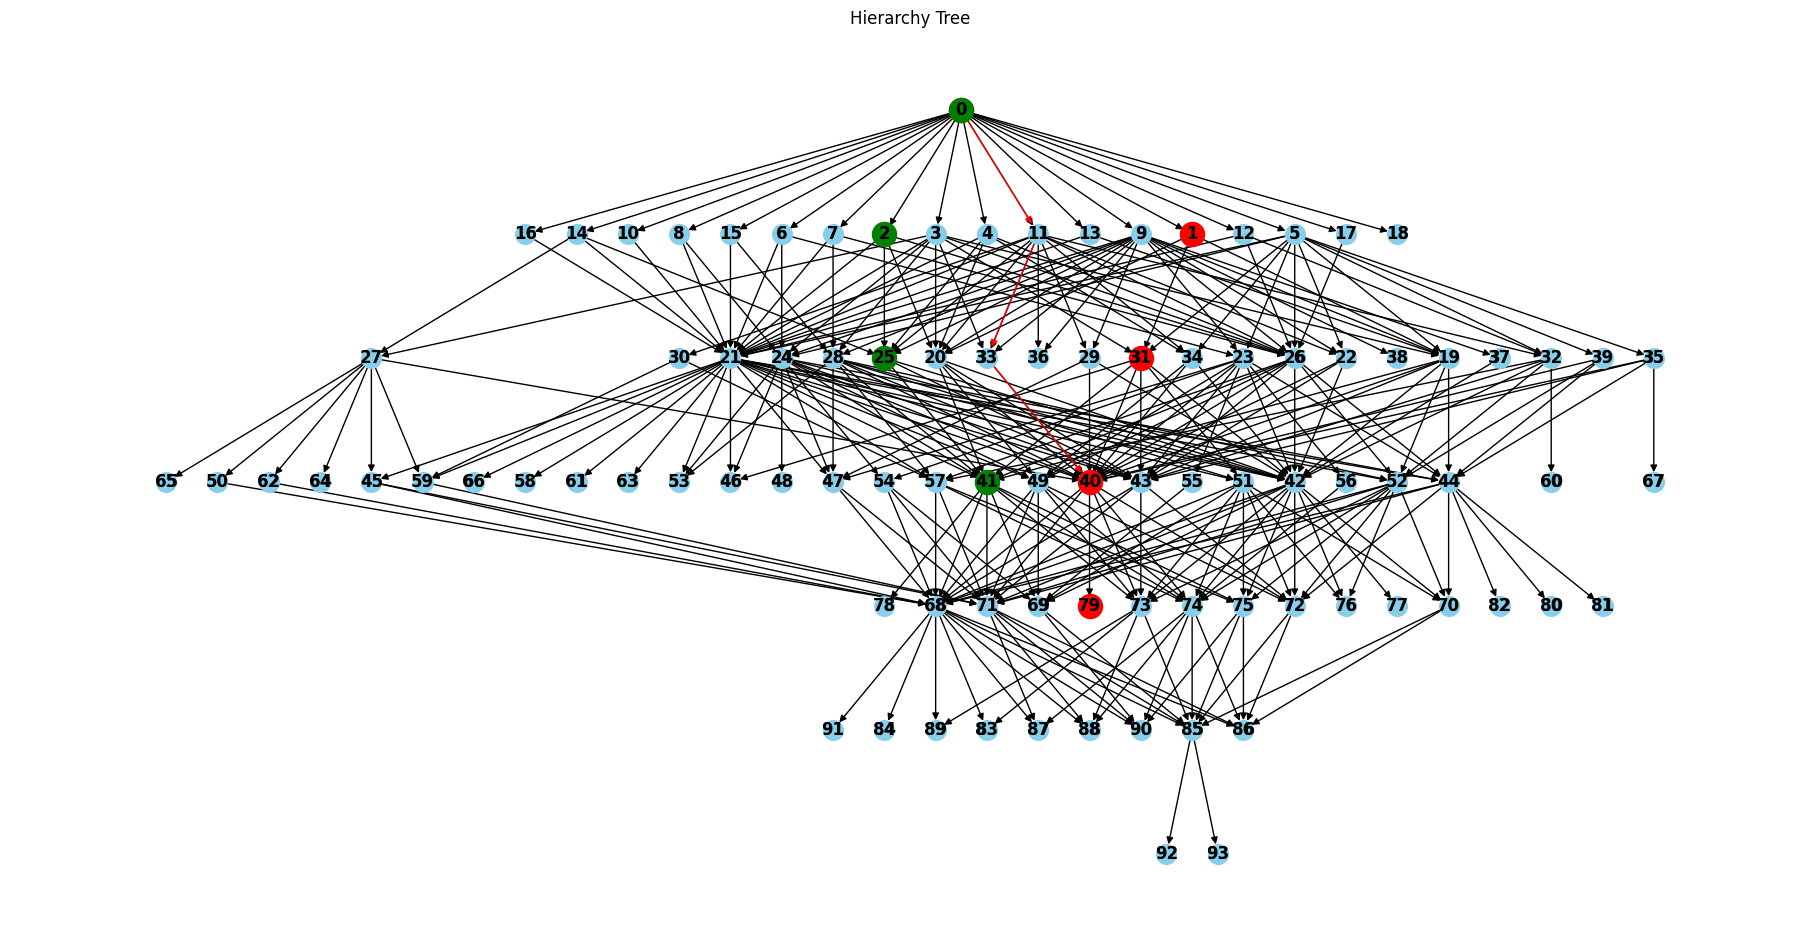

In [17]:
show_hierarchy_graph(G,
                     figsize=(18, 9),
                     nodes=[([0, 1, 31, 40, 79], "r"),
                            ([0, 2, 25, 41], "g")],
                     edges=[([(0, 11), (11, 33), (33, 40)], "r")],
                     graph_kwargs={'node_size': 200,
                                   'node_color': 'skyblue'},
                     nodes_kwargs={'node_size': 300,
                                   'node_color': 'r'},)

In [18]:
d.y_train()[0]

[['11', '02', '01'], ['11', '02', '02'], ['11', '02', '03', '01']]

In [72]:
import importlib
import feature_selection
importlib.reload(feature_selection)

<module 'feature_selection' from 'c:\\Users\\sjtom\\Documents\\MUNI\\Semester jar 2024\\PV056 - Machine Learning and Data Mining\\hiclass\\feature_selection.py'>

In [ ]:
selector = feature_selection.ModSelectKBest(k=10)
selector.fit(d.x_train(expand=True), d.y_train(expand=True))

In [ ]:
d.x_train(expand=True).columns[selector.get_support()]

In [73]:
it_selector = feature_selection.IterativeSelect(x_valid=d.x_valid(expand=False), y_valid=d.y_valid(expand=False), epochs=2, verbose=True)
it_selector.fit(d.x_train(expand=False), d.y_train(expand=False))

N feats:  77


c:\Users\sjtom\Documents\MUNI\Semester jar 2024\PV056 - Machine Learning and Data Mining\hiclass\feature_selection.py:75: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_len = y.apply(len).agg(max)
c:\Users\sjtom\Documents\MUNI\Semester jar 2024\PV056 - Machine Learning and Data Mining\hiclass\feature_selection.py:76: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  depth = y.apply(lambda x: max([len(label) for label in x])).agg(max)


Epoch 1/2: F1 score on validation set 0.43875
Epoch 2/2: F1 score on validation set 0.43359


IterativeSelect(epochs=2, verbose=True,
                x_valid=     cln3-1  cln3-2  clb2-2  clb2-1  ...  elu300  elu330  elu360  elu390
0     -0.07   -0.76   -0.12   -0.25  ...   -0.19    0.08    0.01   -0.02
1     -0.30   -0.60   -0.18    0.01  ...    0.34    0.05   -0.93    0.05
2     -1.22    0.66   -0.64   -0.17  ...   -0.08    0.11   -0.41    0.16
3      0.44   -0.51   -0.22    0.15  ...    0.23    0.08   -0.45    0.25
4      0.98    1.33   -0.27   -0.29  ...   -0.03    0.49    0.04   -0.03
..      ...     ...     ...     ...  ...     ...     ...     ...     ...
843    0.29    1.37   -1.09    0.33  .....
847    0.39   -0.86   -0.69   -0.27  ...   -0.41   -0.03    0.09   -0.17

[848 rows x 77 columns],
                y_valid=0                               [[14, 04], [20, 09, 13]]
1                                             [[42, 16]]
2       [[01, 01, 06, 05, 01, 01], [01, 01, 09, 03, 01]]
3             [[10, 03, 05, 01], [42, 04, 05], [42, 29]]
4                           [[01, 05], [14, 07, 02, 01]]
                             ...                        
843    [[01, 05, 02, 07], [01, 05, 03], [02, 19], [40...
844                             [[12, 01, 01], [42, 16]]
845                             [[01, 06], [14, 07, 01]]
846                   [[02, 11], [02, 13, 03], [14, 10]]
847                                   [[20, 03, 01, 01]]
Name: class, Length: 848, dtype: object)

In [75]:
xt.columns[it_selector.get_support()]

Index(['alpha0', 'alpha105', 'cdc15_50', 'cdc15_90', 'cdc15_140', 'cdc28_80',
       'cdc28_100', 'cdc28_110', 'elu270', 'elu300'],
      dtype='object')

In [60]:
xt = d.x_train(expand=False)

In [62]:
s = np.zeros(xt.shape[1], dtype=bool)
s[np.random.choice(xt.shape[1],
                   10,
                   replace=False)] = True
s

array([False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False,  True, False])

In [70]:
xt.loc[:, s]

,alpha14,alpha35,cdc15_30,cdc15_50,cdc15_190,cdc15_200,cdc15_220,elu90,elu120,elu360
0,-0.21,-0.440000,0.09,-0.23,-0.280000,-0.09,0.31,0.18,-0.24,-0.48
1,0.10,-0.580000,-0.22,-0.16,-0.074762,0.22,0.08,0.39,0.18,0.34
2,-0.47,-0.070000,-1.33,-1.53,-0.074762,1.18,1.80,0.25,-0.45,0.60
3,0.17,0.060000,-0.02,0.00,0.050000,0.29,0.39,0.32,0.12,-0.19
4,0.12,0.250000,0.08,0.11,-0.310000,0.14,0.54,0.09,0.21,0.28
...,...,...,...,...,...,...,...,...,...,...
1623,-0.18,-0.009387,-0.16,0.01,0.110000,0.36,0.50,0.04,0.02,-0.46
1624,0.43,0.080000,-0.20,0.08,-0.260000,0.53,0.59,0.09,0.00,0.00
1625,0.25,0.240000,0.12,0.19,0.300000,-0.06,-0.44,0.41,0.18,-0.30
1626,-0.06,0.120000,-0.21,-0.26,-0.160000,0.49,0.90,0.45,0.13,-0.72
